## 0. 前置知识
### (1)残差块。
结构上，让输入数据**跨层**更快地向前传播。
理论上，让每个附加层都应该更容易地**包含原始函数**作为其元素之一。
其优势是能拟合出更优的解，更容易降低训练误差。
### (2)批量规范化。
##### 待解决的问题
网络层数一多(形如 x → l1 → l2 → l3 → ... → ln → loss 函数)，规范化就不可避免。因为损失函数在最后层，反向传播时后面的层训练的比较快；而前面的层训练较慢。前面的层一变化，后面所有都得跟着变。导致后面的层重新学习了多次。最终导致收敛变慢。批量规范化，就是希望**前面层改变时，后面的层不必重新学**，以**加速收敛**速度，以前的学习率可能是0.01，现在可设lr=0.1。

##### 用在哪里
- 可学习的参数为 $\gamma$和$\beta$
- 作用在
    - 全连接层和卷积层的输出上，激活函数前
    - 全连接层和卷积层的输入上
- 对全连接层，作用在特征维
- 对于卷积层，作用在通道维

##### 具体在做什么
理论还不能解释，深度学习的工程是走在理论前面的。
- 批量归一化**固定**小批量中的**均值**和**方差**，然后学习出适合的偏移和缩放
- 可以加速收敛速度，但一般不改变模型精度

### (3)Embedding
将字词变成向量，两个近义词有更近的向量距离。
Embedding层，在某种程度上，就是用来降维的，降维的原理就是**矩阵乘法**。
假如我们有一个(10W,10W)的矩阵，用它乘上一个(10W,20)的矩阵，我们可以把它降到(10W,20)，瞬间量级降了10W/20=5000倍

## 1. 模型
采用的注意力评分函数是缩放点积评分。
### (1) 编码器
编码器是由多个相同的层叠加而成的，每个层都有两个子层 sublayer:
- 自注意力层
- 基于位置的前馈网络

编码器在计算自注意力时，查询、键和值都来自前一个编码器层的输出。
因为采用了残差连接，要求输入的$X$在流经网络时尺寸不得发生变化。即对于序列中任何位置的任何输入
$x \in \mathbb{R}^d$，都要求满足$sublayer(x) \in \mathbb{R}^d$，以便残差连接满足$$x + sublayer(x) \in \mathbb{R}^d$$。

在残差连接的加法计算之后，紧接着应用层规范化(layer normalization)

### (2) 解码器

第一个遮蔽多头注意力 sublayer 使用遮蔽矩阵，要求解码器中的每个位置只能考虑该位置之前的所有位置，确保预测仅依赖于已生成的输出词元。

编码器是双向的，编码时能看到句子上下文，不需要隐蔽矩阵。而解码器是单向的，只允许看到当前单词之前的部分，因此要安排遮蔽矩阵

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 2. 基于位置的前馈网络
对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP）,将输入形状从 (batch_size,num_step,dim) → (batch_size * num_step,dim) 。
PyTorch对于 dim>2 的输入，前 n-1 维均视作样本维，最后一个维度视为features 维。
也就是说，不再分别考虑一批有几个时间步以及一个时间步里有几个元素，直接对每个元素进行全连接。

输入 $x$: (batch_size,num_step,features)  （此处设置 features == num_hiddens）
通过一个两层的感知机: (features,num_hidden,num_outputs),转为
输出: (batch_size,num_step,num_outputs)

In [2]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""

    def __init__(self, ffn_num_input, ffn_num_hiddens, fnn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, fnn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


举例：验证基于位置的前馈网络的数据流转

In [3]:
# num_input,num_hidden,num_output
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
# (2,3)视作样本维，(4)视作 feature 维。样本维在流经网络后保持数目不变，featurn 维度变成 num_output
ffn(torch.ones(2, 3, 4)).shape

torch.Size([2, 3, 8])

## 3. 残差连接和层规范化（add & norm）
在NLP中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。（见 https://www.bilibili.com/video/BV1Kq4y1H7FL/?spm_id_from=333.999.0.0&vd_source=46af8e25a61e33c10249cebb913791e3 14:35 处，其中 b 是一批的（时间步数/样本数），len 是一个（时间步/样本）的元素数，d 是一个元素的特征数）

- 批量归一化：对一个 batch 里全部数据的同一个特征/通道进行归一化，不适合序列长度会变的NLP应用
- 层归一化：对一个 batch 里的一个样本里的全部元素进行归一化

In [4]:
ln = nn.LayerNorm(2)  # 每个 batch 单独进行归一化
bn = nn.BatchNorm1d(2)  # 所有 batch 一起进行归一化

X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


使用残差连接和层规范化来实现AddNorm类

In [5]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""

    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)  # dropout(Y) + X 即残差操作，ln()进行规范化

残差连接要求两个输入的形状相同，加法操作后输出张量的形状也一致。
残差连接要求数据尾部维度 == 给定的 norm_shape

In [6]:
add_norm = AddNorm([3, 4], 0.5)         # 对[*,3,4] 的矩阵进行残差 & 归一化
add_norm.eval()
add_norm(torch.ones((12,2, 3, 4)), torch.ones((12,2, 3, 4))).shape #

torch.Size([12, 2, 3, 4])

## 4.编码器
编码器的两个 `sublayer` 已经定义完成，开始构造编码器的单层组件

In [7]:
class EncoderBlock(nn.Module):
    """Transformer 编码器块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

编码器中的任何层都不会改变其输入的形状。

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5) # 注意相等限制：norm_shape=[100,24],那么 X 的最后两维=(100,24)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [108]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""

    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)  # 每个嵌入向量的大小 = num_hiddens (生成的输入数据的最后一维是 num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blocks = nn.Sequential()

        # 编码器第 i 层自注意力接受的查询、键和值都来自第 i-1 层的自注意力的输出
        for i in range(num_layers): # num_layers 是一个 int object,想用 for...in... 遍历必须添加range()
            self.blocks.add_module("block" + str(i),
                                   EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                                ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为 pos_encoding 值域在-1和1之间，而 embedding(X) 的值域又随着 num_hiddens 的增大而减小(容易想到，一个单词如果用越长的向量表示，那向量中的每个值就不需要太大)
        # 因此嵌入值乘以嵌入维度的平方根进放大，这样 pos_encoding 和 embedding(X) 的规模就差不多大了，然后两者相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blocks)  # 该属性用于可视化
        for i, blk in enumerate(self.blocks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X


下面我们指定了超参数来创建一个$2$层的Transformer编码器。
Transformer编码器输出的形状是（批量大小，时间步数目，num_hiddens）。

In [139]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

关于 nn.Embedding()

In [110]:
# @param:   num_embeddings      嵌入词表的尺寸
# @param:   embedding_dim       要求每个嵌入向量的size，transformer 要求为 3
embedding = nn.Embedding(10, 3)

# a batch of 2 samples of 4 indices each
i = torch.LongTensor([[1, 2, 3, 4, 5], [2, 2, 3, 4, 5]])
embedding(i)

tensor([[[-0.4835, -0.1889, -0.2462],
         [ 1.2793,  0.0050, -0.5601],
         [-0.5755,  0.2861,  0.9535],
         [-0.6942, -0.2362,  1.1656],
         [ 0.8318, -0.6074, -0.5397]],

        [[ 1.2793,  0.0050, -0.5601],
         [ 1.2793,  0.0050, -0.5601],
         [-0.5755,  0.2861,  0.9535],
         [-0.6942, -0.2362,  1.1656],
         [ 0.8318, -0.6074, -0.5397]]], grad_fn=<EmbeddingBackward0>)

## 5. 解码器
由多个相同的层组成。
在DecoderBlock 类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。
这些子层也都被 Addnorm 层规范化围绕。

参数dec_valid_lens 确保任何查询都只会与解码器中所有**已经生成词元**的位置（即直到该查询位置为止）进行注意力计算。
> 关于序列到序列模型（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，**只有生成的词元才能用于解码器的自注意力计算中**。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

预测第 $t+1$ 个输出时，解码器中输入前 $t$ 个预测值。其中
前 $t$ 个预测值作为 key 和 value,第 $t$ 个预测值还作为 query

In [9]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i  # 标识当前第 i 个 block
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)

        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)

        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        # Decoder 用参数 state 接受 Encoder 的 Output
        enc_outputs, enc_valid_lens = state[0], state[1]

        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values

        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens.shape = (batch_size,num_steps),其中每一行是[1,2,...,num_steps]
            # 作用是在 training 时遮掉当前词之后的词。
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1) # 行数倍增到 batch_size 倍，列不变
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X,key_values,key_values,dec_valid_lens) # 查询、键和值都来自前一层的自注意力的输出。training 时 X 就是 key_values 本身
        Y = self.addnorm1(X,X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # 查询来自前一个解码器层的输出，键和值来自整个编码器的输出。
        Z = self.addnorm2(Y,Y2)

        # 将本层的 state 传递给下一层
        return self.addnorm3(Z,self.ffn(Z)),state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens。

In [112]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()

X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Transformer 解码器

In [113]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)     # 作为输出层，效果是将元素的长度从 hidden -> vocab_size

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state) # 每层更新一次 X(向量化后的一批单词，用于做自注意力的Q、K、V) 和 state(编码器的 输出和掩码)

            # 保存解码器层每个单层的 2 个自注意力模块的全部权重参数，用于可视化
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights

        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

编码器-解码器架构
（编码器 → 解码器） → 网络输出

In [114]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.
    Defined in :numref:`sec_encoder-decoder`"""

    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args) # enc_valid_lens 好像没传
        return self.decoder(dec_X, dec_state)

## 6.训练
实例化编码器－解码器模型。
指定Transformer的编码器和解码器都是2层，都使用4头注意力。
使用“英语－法语”机器翻译数据集训练 Transformer 模型

In [119]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_seq2seq_decoder`"""

    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.030, 1511.2 tokens/sec on cuda:0


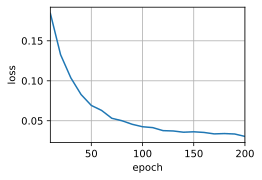

In [120]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

net = EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 7. 评估
训练结束后，使用Transformer模型将一些英语句子翻译成法语，并且计算它们的BLEU分数

In [121]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


## 8.可视化Transformer的注意力权重。
### (1)编码器
编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键－值”对的数目）。

In [122]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

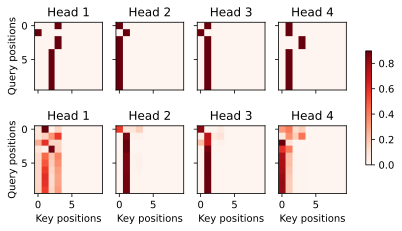

In [123]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

可以看到每一个 head 所注意到的都不太一样。
每一行是一个 Query，每一列是一个 Key-Value pair。每个元素表示 $Q_i$ 对 $(K_i,v_i)$ 的关注度。

### (2) 可视化解码器的自注意力权重和“编码器－解码器”的注意力权重

In [124]:

dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

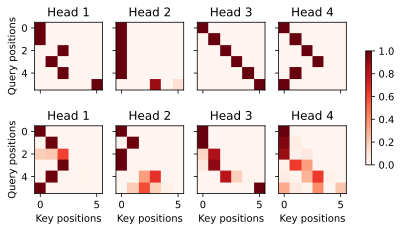

In [125]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

## QA
1. 多头注意力，concat和相加取平均，怎么选择呢？
> 尽量 concat,在保留每个头原有信息方面好于加权平均

2. Transformer 为什么在获取词向量之后，需要对词向量进行缩放？(乘以embedding sizel的开方之后再加上PE)
> 详见 TransformerEncoder 的 forward() 。embedding 化的特点是，要求生成的向量长度(embedding_size)越长，其内每一个元素的值的值域就会非常小。乘以sqrt(embedding_size)是为了和位置编码相加时**保持差不多的值规模**。

3. 采用多头有什么好处？
> 同时有好几个小的 attention 识别不同的特征，效果类似于 CNN 的多通道。

4. 训练 transformer 的最低硬件要求，如果需要几千张GPU，那么大部分人怎么复现它？
> transformer 的最低训练要求不高，高的是 BERT / GPT

5. $K,V,Q$大小一般怎么选择呢?
> 就是 hidden_size

6. 看论文时很多模型只使用了encoder,.没有用decoder,想问下区别在哪里，有什么选择依据呢？
> BERT 就是只用了 Encoder，详见 BERT

7. 